In [1]:
import numpy as np
import os
import os.path as osp
import tqdm
import torch 
import json
import sys
import logging
from torch import optim
import torch.nn.functional as func
import random
from datetime import datetime


from utils import common_tools as ct


from torch.utils.data import DataLoader, dataloader, Dataset

from sklearn.preprocessing import StandardScaler
import pandas as pd
from utils.timefeatures import time_features

TRAIN_RATIO = 0.7 
TEST_RATIO = 0.2
class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTm1.csv',
                 target='OT', scale=True, timeenc=0, freq='t'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Custom(Dataset):
    global TRAIN_RATIO, TEST_RATIO
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        # print(cols)
        num_train = int(len(df_raw) * TRAIN_RATIO)
        num_test = int(len(df_raw) * TEST_RATIO)
        num_vali = len(df_raw) - num_train - num_test
        print(num_train, num_vali, num_test, TRAIN_RATIO, TEST_RATIO, len(df_raw))
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len] # this line changed
        # border1s = [0, num_train - self.seq_len, num_train - self.seq_len] # this line changed
        # border2s = [num_train, len(df_raw), len(df_raw)] # this line changed
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]
        #! before align the position, you have to set scale = False
        # self.scale = False
        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            # print(self.scaler.mean_)
            # exit()
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        # print(self.data_x[336 ,123],self.data_x[0,123], border1, border2, self.set_type)
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    

class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, inverse=False, timeenc=0, freq='15min', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
            cols.remove(self.target)
        else:
            cols = list(df_raw.columns)
            cols.remove(self.target)
            cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


def process_data_stream(args):
    df_raw = pd.read_csv('./data/' + args.data_name + ".csv")  #!注意 normalize只在Custom做了更改 ,之后如果跑ETT数据集要注意了
    # scaler = StandardScaler()
    # scaler.fit(df_raw.values)
    # df_raw = scaler.transform(df_raw.values)
    # df_raw = pd.DataFrame(df_raw)

    t = 0; tmp_phase = 0
    while tmp_phase < args.end_phase:
        df_phase = df_raw[t:t+args.phase_len]
        print(t, t+args.phase_len)
        # write df_phase to file "data_path_phase_{}.csv".format(tmp_phase)
        tmp_path = './data/'  + args.data_name + "/" + str(args.end_phase) 
        # check if path exist, if not, create it
        if not os.path.exists(tmp_path):
            os.makedirs(tmp_path) 

        df_phase.to_csv('./data/'  + args.data_name + "/" + str(args.end_phase) + "/" + "_phase_{}.csv".format(tmp_phase), index=False)
        t += int(args.phase_len * args.val_ratio)
        tmp_phase += 1

data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
    'ETTm1': Dataset_ETT_minute,
    'ETTm2': Dataset_ETT_minute,
    'custom': Dataset_Custom,
}

def get_noise_label(Score, noise_rate, enc_in): 
    # sort Score from small to large, label the biggest noise_rate as 1, return a list of labels
    noise_label = np.zeros((len(Score), enc_in))
    # print(noise_label.shape)
    # Score = np.arange(len(Score))
    # print(Score, noise_label.shape)
    idx = np.argsort(-Score, axis=0)
    # print(idx[:100])
    tmp = np.arange(enc_in).reshape(1, -1)
    tmp = np.tile(tmp, int(len(Score)*noise_rate)).reshape(int(len(Score)*noise_rate), -1)
    # print(idx[:int(len(Score)*noise_rate)].shape, tmp.shape, "wew")
    noise_label[idx[:int(len(Score)*noise_rate)], tmp] = 1
    # print(int(len(Score)*noise_rate), "noise rate: ", np.sum(noise_label)/len(noise_label))
    # print(noise_label[:100])
    # print(noise_label.shape)
    return noise_label 

class new_DS(Dataset):
    def __init__(self, ds, args, flag):
        self.args = args
        self.flag = flag 
        self.data = ds
        args.enc_in = ds[0][0].shape[1] if args.idx == -1 else 1
        # args.Score = np.random.uniform(0,1,len(self.data))

        # if hasattr(args, "Score") == False: 
        # if args.flag != 'train' or hasattr(args, "Score") == False: args.Score = np.random.uniform(0,1,len(self.data))
        # print(len(args.Score), len(self.data))
        
        # args.Score = np.random.uniform(0,1,len(self.data))
        self.noise_label = np.zeros((len(self.data), args.enc_in))
        if args.get_score == True and args.flag == 'train': #todo
            self.noise_label = get_noise_label(args.Score, args.noise_rate, args.enc_in)
        self.index = np.arange(len(self.data))

    def __len__(self):
        return len(self.index)
    def __getitem__(self, idx):
        if self.args.idx == -1: 
            return (self.data[self.index[idx]][0]), (self.data[self.index[idx]][1]), (self.data[self.index[idx]][2]), (self.data[self.index[idx]][3]), self.noise_label[idx]
        return (self.data[self.index[idx]][0])[:,self.args.idx].reshape(-1,1), (self.data[self.index[idx]][1])[:,self.args.idx].reshape(-1,1), (self.data[self.index[idx]][2]), (self.data[self.index[idx]][3]), self.noise_label[idx]
          

def data_provider(args, flag):
    data_label = args.data_name
    if args.data_name != "ETTh2" and args.data_name != "ETTm1": data_label = "custom"
    Data = data_dict[data_label]
    timeenc = 0 if args.embed != 'timeF' else 1

    args.flag = flag
    if flag == 'test' or flag == 'val':
        shuffle_flag = False
        drop_last = False
        batch_size = args.batch_size
        freq = args.freq
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
        Data = Dataset_Pred
    elif flag == 'train' and args.start_train == 0: 
        shuffle_flag = False
        drop_last = False
        batch_size = args.batch_size
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        scale=True
    )

    data_set = new_DS(data_set, args, flag) #* multivariate -> univariate
    
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    
    return data_set, data_loader
    

def get_dataset(args):
    global TRAIN_RATIO, TEST_RATIO
    if args.end_phase > 1:  
        TRAIN_RATIO = 0.5 
        TEST_RATIO = 0.05
    args.save_data_path = "data/processed_data/" + args.data_name + "/"
    args.data_path = './data/' + args.data_name + "/" + str(args.end_phase) +  "/" + "_phase_" + str(args.phase) + '.csv'

    if args.data_process:
        process_data_stream(args)
        args.data_process = False 
            
    inputs = {}
    _, inputs["train_loader"] = data_provider(args, 'train')     
    _, inputs["val_loader"] = data_provider(args, 'val')
    ds, inputs["test_loader"] = data_provider(args, 'test')
    # print(len(ds), ds[0][0].shape[0], ds[0][0].shape)
    args.nodes = torch.arange(ds[0][0].shape[1])
    args.enc_in = args.dec_in = args.c_out = len(args.nodes)

    return inputs 



/Disk/fhyega/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class Args:
    def __init__(self) -> None:
        pass 

args = Args()
args.jitter_sigma, args.device, args.data_name, args.conf = (0.01, "cuda:0", "ETTh2", "ECL-PatchTST") 

with open("configs/" + args.conf + ".json", "r") as f:
    config = json.load(f)
    for key, value in config.items():
        if not hasattr(args, key):
            setattr(args, key, value)
args.logname = args.conf
args.device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
args.time = datetime.now().strftime("%Y-%m-%d-%H:%M:%S.%f")
args.path = osp.join("we", args.logname+args.time)
args.num_workers = 4
args.start_train = 0
args.train_mode = 'pretrain'
args.get_score = False
args.use_cm = True
args.root_path = ""
args.phase = 0
args.idx = -1
args.enhance_type = 3
args.slope_rate = 0.01
args.slope_range = 0.5
args.jitter_sigma = 0.2


In [3]:
inputs = get_dataset(args) 
_, train_loader = data_provider(args, 'train')

0 26304
train 8209
val 2785
test 2785
train 8209


In [8]:
from typing import Any
import torch
import torch.nn as nn
from torch import einsum
import torch.nn.functional as F
import numpy as np

class Enhancer(object):
    def __init__(self, args) -> None:
        self.args = args
        self.jitter_sigma = args.jitter_sigma 
        self.slope_rate = args.slope_rate
        self.slope_range = args.slope_range

    def identity(self, x): 
        return x 

    def jitter(self, x):
        # use the plot to visualize x[3]
        # import matplotlib.pyplot as plt

        # plt.plot(x[3].cpu().numpy()) 
        # plt.savefig('before.png')
        # plt.close()

        x = x + torch.randn(size=x.shape).to(self.args.device) * self.jitter_sigma 
        # plt.plot(x[3].cpu().numpy()) 
        # plt.savefig('after.png')
        return x

    def spike(self, x): 
        x = x.permute(0, 2, 1)

        # import matplotlib.pyplot as plt
        # print(x[3].shape)
        # plt.plot(x[3][1].cpu().numpy()) 
        # plt.savefig('before1.png')
        # plt.close()
        
        idx = torch.randint(low=0, high=self.args.seq_len-1, size=(x.shape[0], x.shape[1], 1), device=x.device) 
        amplify = torch.randint(low=5, high=12, size=(x.shape[0], x.shape[1], 1), device=x.device) #todo
        sign = torch.sign(torch.randn( size=(x.shape[0], x.shape[1], 1), device=x.device)) 
        print(sign)
        max_value = torch.max(x, dim=-1, keepdim=True)[0] 
        # print(max_value, max_value.shape)
        # convert every number in idx to a three dimentional vector, first two dimention is the index of the number, the third dimention is the number itself
        first_axis = torch.arange(x.shape[0], device=x.device).reshape(x.shape[0], 1, 1).repeat(1, x.shape[1], 1)
        second_axis = torch.arange(x.shape[1], device=x.device).reshape(1, x.shape[1], 1).repeat(x.shape[0], 1, 1)

        # idx = torch.cat([first_axis, second_axis, idx], dim=-1).reshape(-1, 3)
        x[first_axis, second_axis, idx] += sign * max_value * amplify 
        # plt.plot(x[3][1].cpu().numpy()) 
        # plt.savefig('after1.png')
        # plt.close()
        
        return x.permute(0, 2, 1) 

    def substitude(self, x): 
        if x.shape[2] == 1: return x
        x = x.permute(0, 2, 1)
        # import matplotlib.pyplot as plt
        # plt.plot(x[3][1].cpu().numpy()) 
        # plt.savefig('before2.png')
        # plt.close()
        b = x.shape[0] 
        for i in range(b): 
            c_idx = torch.randint(low=0, high=x.shape[1] - 1, size=(x.shape[1],), device=x.device) 
            t_idx = torch.randint(low=0, high=x.shape[2] - 48, size=(1,), device=x.device) 
            x[i, :, t_idx:t_idx+48] = x[max(i - 1, 0), c_idx, t_idx:t_idx+48] #todo
            #* change here 
        # plt.plot(x[3][1].cpu().numpy()) 
        # plt.savefig('after2.png')
        # plt.close()
        # exit(0)
        return x.permute(0, 2, 1)
    
    def l_slope(self, x): 
        x = x.permute(0, 2, 1)
        
        add_slope = torch.concat([torch.arange(0, int(self.slope_range * x.shape[-1])).flip(dims=[0]) * (torch.rand((1,)) + 0.5) * self.slope_rate, torch.zeros(x.shape[-1] - int(self.slope_range * x.shape[-1]))])
        add_slope = add_slope.reshape(1, 1, -1) 
        add_slope = add_slope.repeat(x.shape[0], x.shape[1], 1) 
        
        x = x + add_slope.to(self.args.device)
        return x.permute(0, 2, 1)
    
    def r_slope(self, x): 
        x = x.permute(0, 2, 1)
        
        add_slope = torch.concat([torch.zeros(x.shape[-1] - int(self.slope_range * x.shape[-1])), torch.arange(0, int(self.slope_range * x.shape[-1])) * (torch.rand((1,)) + 0.5) * self.slope_rate])
        add_slope = add_slope.reshape(1, 1, -1) 
        add_slope = add_slope.repeat(x.shape[0], x.shape[1], 1) 
        
        x = x + add_slope.to(self.args.device)
        return x.permute(0, 2, 1)
    
    def set_zero(self, x): 
        if x.shape[2] == 1: return x
        x = x.permute(0, 2, 1)
        # import matplotlib.pyplot as plt
        # plt.plot(x[3][1].cpu().numpy()) 
        # plt.savefig('before2.png')
        # plt.close()
        b = x.shape[0] 
        for i in range(b): 
            c_idx = torch.randint(low=0, high=x.shape[1] - 1, size=(x.shape[1],), device=x.device) 
            t_idx = torch.randint(low=0, high=x.shape[2] - 48, size=(1,), device=x.device) 
            x[i, :, t_idx:t_idx+48] = 0 #todo
        # plt.plot(x[3][1].cpu().numpy()) 
        # plt.savefig('after2.png')
        # plt.close()
        # exit(0)
        return x.permute(0, 2, 1)

    def __call__(self, x) -> Any:
        bs = x.shape[0] // 4
        if self.args.enhance_type == 1: 
            x = torch.cat([x[:bs], self.jitter(x[bs:])], dim=0)
        elif self.args.enhance_type == 2:     
            x = torch.cat([x[:bs], self.spike(x[bs:])], dim=0)
        elif self.args.enhance_type == 3: 
            x = torch.cat([x[:bs], self.substitude(x[bs:])], dim=0)
        elif self.args.enhance_type == 4: 
            x = torch.cat([x[:bs], self.l_slope(x[bs:])], dim=0)
        elif self.args.enhance_type == 5: 
            x = torch.cat([x[:bs], self.substitude(x[bs:])], dim=0)
            x = torch.cat([x[:bs], self.set_zero(x[bs:])], dim=0)    
        else:
            x = torch.cat([x[:bs], self.jitter(x[bs:bs*2]), self.spike(x[bs*2:bs*3]), self.substitude(x[bs*3:])], dim=0)
            x = torch.cat([x[:bs], self.l_slope(x[bs:bs*2]), self.l_slope(x[bs*2:bs*3]), self.set_zero(x[bs*3:])], dim=0)
        return x
    

enhancer = Enhancer(args)
    

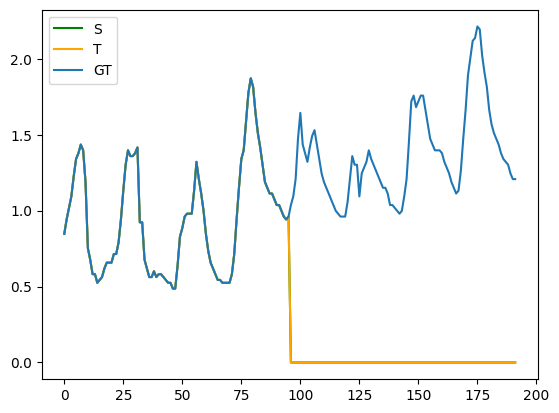

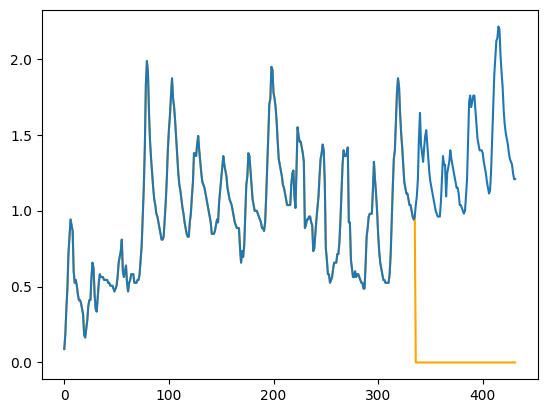

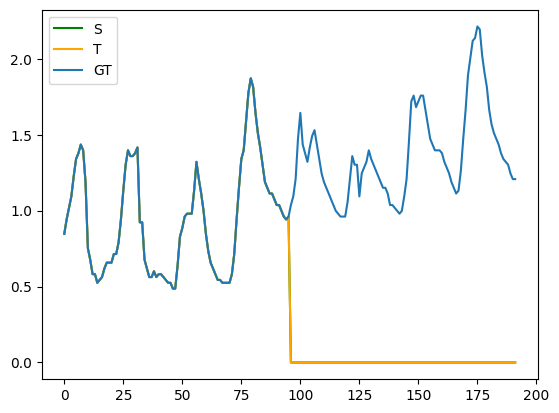

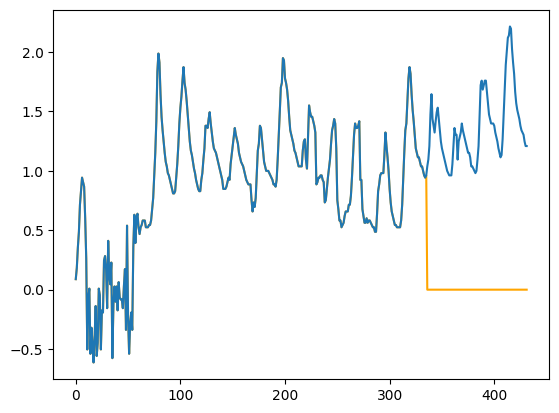

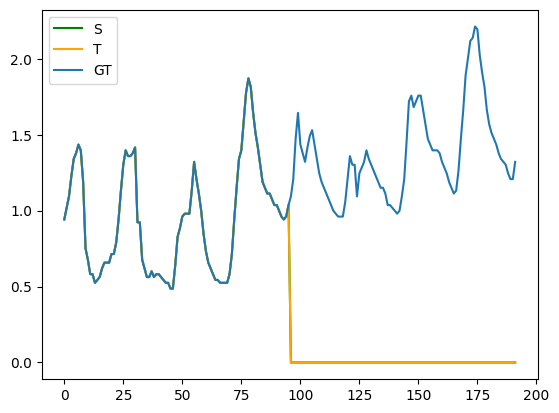

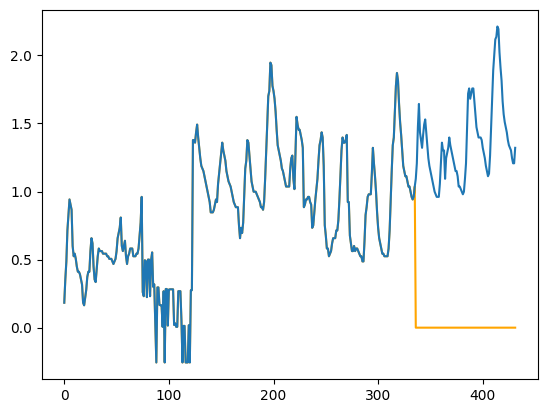

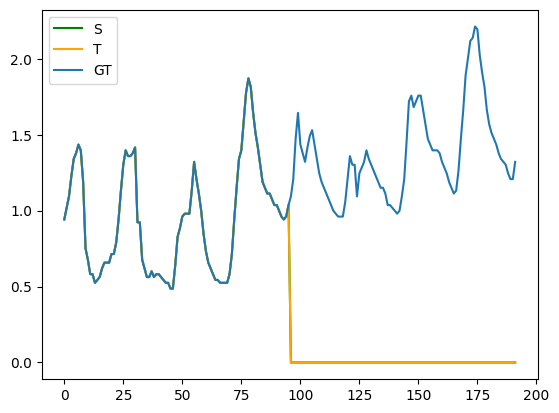

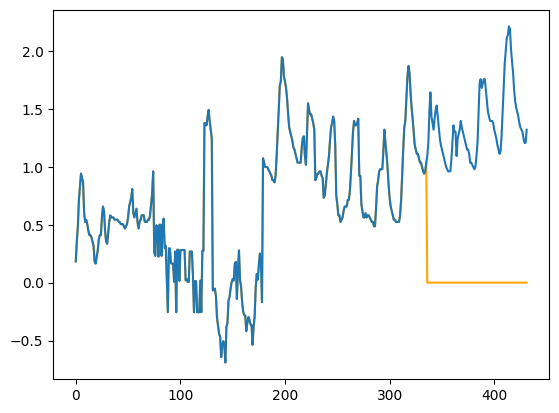

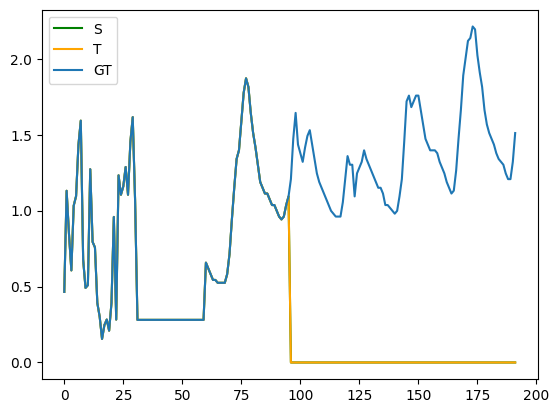

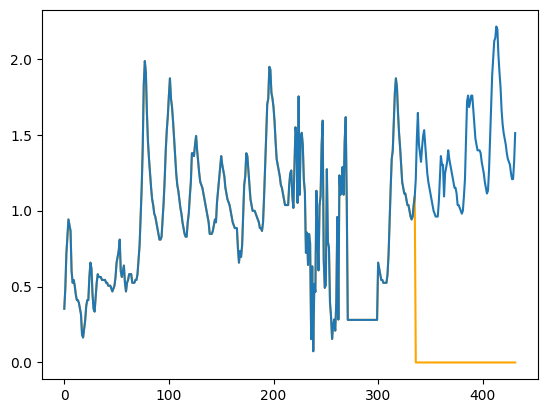

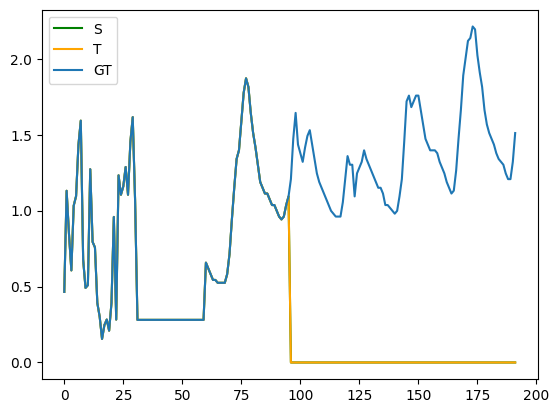

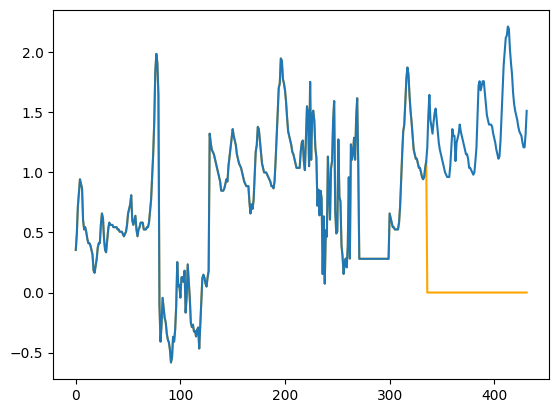

In [12]:


for batch_idx, (batch_x, batch_y, batch_x_mark, batch_y_mark, label) in enumerate(train_loader):
    batch_x = batch_x.float().to(args.device)
    batch_y = batch_y.float().to(args.device)
    batch_x_mark = batch_x_mark.float().to(args.device)
    batch_y_mark = batch_y_mark.float().to(args.device)
    batch_y = batch_y[:, -args.pred_len:, :].to(args.device)

    def vis(idx, channel): 
        import matplotlib.pyplot as plt 
        pred_S, F_S = torch.zeros_like(batch_y.cpu()), 1
        pred_T, F_T = torch.zeros_like(batch_y.cpu()), 1
        plt.plot(torch.cat([batch_x[idx,-96:,channel].cpu(), pred_S[idx,:,channel].cpu()]).detach().numpy(), color='g') 
        plt.plot(torch.cat([batch_x[idx,-96:,channel].cpu(), pred_T[idx,:,channel].cpu()]).detach().numpy(), color='orange') 
        plt.plot(torch.cat([batch_x[idx,-96:,channel].cpu(), batch_y[idx,:,channel].cpu()]).detach().numpy())
        plt.legend(['S', 'T', 'GT'])
        # show loss by text
        # plt.text(0,0, "loss S: {:.5f}; loss T: {:.5f}".format(self.lossfunc(batch_y[idx,:,channel], pred_S[idx,:,channel],reduction='mean').item(), self.lossfunc(batch_y[idx,:,channel], pred_T[idx,:,channel],reduction='mean').item()))
        plt.savefig('before{}.png'.format(1))
        plt.show()
        plt.close()

        plt.plot(torch.cat([batch_x[idx,:,channel].cpu(), pred_T[idx,:,channel].cpu()]).detach().numpy(), color='orange') 
        plt.plot(torch.cat([batch_x[idx,:,channel].cpu(), batch_y[idx,:,channel].cpu()]).detach().numpy())
        plt.savefig('all{}.png'.format(1))
        plt.show()
        plt.close()

        import matplotlib.pyplot as plt 
        batch_x_ = enhancer(batch_x)
        pred_S, F_S = torch.zeros_like(batch_y.cpu()), 1
        pred_T, F_T = torch.zeros_like(batch_y.cpu()), 1
        plt.plot(torch.cat([batch_x_[idx,-96:,channel].cpu(), pred_S[idx,:,channel].cpu()]).detach().numpy(), color='g') 
        plt.plot(torch.cat([batch_x_[idx,-96:,channel].cpu(), pred_T[idx,:,channel].cpu()]).detach().numpy(), color='orange') 
        plt.plot(torch.cat([batch_x_[idx,-96:,channel].cpu(), batch_y[idx,:,channel].cpu()]).detach().numpy())
        plt.legend(['S', 'T', 'GT'])
        # show loss by text
        # plt.text(0,0, "loss S: {:.5f}; loss T: {:.5f}".format(self.lossfunc(batch_y[idx,:,channel], pred_S[idx,:,channel],reduction='mean').item(), self.lossfunc(batch_y[idx,:,channel], pred_T[idx,:,channel],reduction='mean').item()))
        plt.savefig('before{}.png'.format(1))
        plt.show()
        plt.close()

        plt.plot(torch.cat([batch_x_[idx,:,channel].cpu(), pred_T[idx,:,channel].cpu()]).detach().numpy(), color='orange') 
        plt.plot(torch.cat([batch_x_[idx,:,channel].cpu(), batch_y[idx,:,channel].cpu()]).detach().numpy())
        plt.savefig('all{}.png'.format(1))
        plt.show()
        plt.close()

    vis(80, 6)
    vis(81, 6)
    vis(82, 6)

    break